# Обнаружение SQL Инъекций

In [1]:
import pandas as pd
df = pd.read_csv('data/sqli.csv', header=None).append(pd.read_csv('data/sqliv2.csv', header=None))
df

,0,1
0,a,1
1,a',1
2,a' --,1
3,a' or 1 = 1; --,1
4,@,1
...,...,...
33755,syrett,0
33756,arrechea bellveh,0
33757,1664,0
33758,almaluez,0


## Данные
Набор содержит примерно 25000 экземпляров нормальных параметров запроса и примерно в 2 раза меньше экземпляров инъекций.

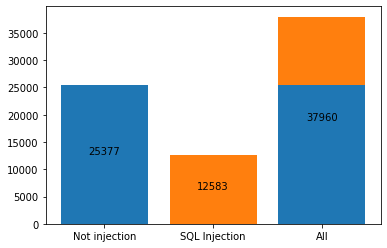

In [2]:
import matplotlib.pyplot as plt
xs, ys = ['Not injection', 'SQL Injection', 'All',], [len(df[df[1] == 0][1]), len(df[df[1] == 1][1]), len(df[df[1] == 0][1]),]
plt.bar(xs, ys, color=['tab:blue', 'tab:orange', 'tab:blue',])
plt.bar(['Not injection', 'SQL Injection', 'All',], [0, 0, len(df[df[1] == 1][1]),], bottom=ys, color=['tab:orange'])
plt.annotate(f'{len(df[1])}', ('All', len(df[1])), xytext=('All', len(df[1]) / 2), ha='center')
for x, y in zip(xs[:2], ys[:2]):
    plt.annotate(f'{y}', (x, y), xytext=(x, y / 2), ha='center')
plt.show()

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Препросессинг
1. Токенезация
2. Приведение к нижнему регистру
3. Лемматизация
4. Удаление стоп-слов
5. Конкатенация токенов

In [4]:
lowerize = lambda tokens: (token.lower() for token in tokens)

### Удаление стоп-слов
Исключаются только английские стоп-слова, которые не являются ключевыми в SQL.

In [5]:
from nltk.corpus import stopwords
sql_keywords = {'or', 'and', 'select', 'union', 'from', 'where', 'in', 'drop', 'database', 'all', 'any', 'order', 'delete', 'is', 'not', 'join', 'by',}
stop_words = set(stopwords.words('english')) - sql_keywords
rm_stop_words = lambda tokens: (token for token in tokens if token not in stop_words)

### Лемматизация
Проводится только по словам которые присутсвуют в лемматизаторе WordNet.

In [6]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatize = lambda tokens: (lemmatizer.lemmatize(token) for token in tokens)

In [7]:
from nltk.tokenize import word_tokenize
concat = lambda tokens, sep=' ': sep.join(tokens)

In [8]:
from functools import reduce
compose = lambda funcs: lambda args: reduce(lambda prev, cur: cur(prev), funcs, args)
preprocess = lambda text: compose(prepocessers)(text)

## Векторизаторы
Используются *Количественный векторизатор* и *TF векторизатор*. Можно также попробовать использовать *TF-IDF векторизатор* или попробовать задать параметры.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizers = (CountVectorizer(), TfidfVectorizer(use_idf=False),)

## Классификаторы
Используются *Логистическая регрессия*, *SVM*, *KNN* и *Наивный байес*. Можно добавить ещё или параметры попробовать задать.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
classifiers = (LogisticRegression(random_state=42), SVC(random_state=42), MultinomialNB(), KNeighborsClassifier(),)

## Метрики
* Accuracy
* F1
* Precision
* Recall

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
scores = (accuracy_score, f1_score, precision_score, recall_score,)

In [12]:
from sklearn.metrics import plot_confusion_matrix
def fit_predict(classifier, vectorizer, classifier_idx=None, vectorizer_idx=None, verbose=False):
    transformed_X_train = vectorizer.fit_transform(X_train)
    transformed_X_test = vectorizer.transform(X_test)
    y_pred = classifier.fit(transformed_X_train, y_train).predict(transformed_X_test)
    clf_title = classifier.__class__.__name__ + ' + ' + vectorizer.__class__.__name__
    if classifier_idx is not None or vectorizer_idx is not None:
        if len(vectorizers) == 1 or len(classifiers) == 1:
            ax[max(vectorizer_idx, classifier_idx)].set_title(clf_title)
            plot_confusion_matrix(classifier, transformed_X_test, y_test, normalize='true', ax=ax[max(vectorizer_idx, classifier_idx)])
        else:
            ax[vectorizer_idx, classifier_idx].set_title(clf_title)
            plot_confusion_matrix(classifier, transformed_X_test, y_test, normalize='true', ax=ax[vectorizer_idx, classifier_idx])
    if verbose is True:
        _, lax = plt.subplots()
        lax.set_title(clf_title)
        plot_confusion_matrix(classifier, transformed_X_test, y_test, normalize='true', ax=lax)
        plt.show()
    return clf_title, y_pred

Сначала обрабатывается вся выборка, потом она разбивается на обучающую и тестовую. Далее в составлении векторизатора используется только обучающая для чистоты эксперимента.

In [13]:
from sklearn.model_selection import train_test_split
prepocessers = (word_tokenize, lowerize, lemmatize, rm_stop_words, concat,)
X = [preprocess(text) for text in df[0].values.astype('U')]
y = df[1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

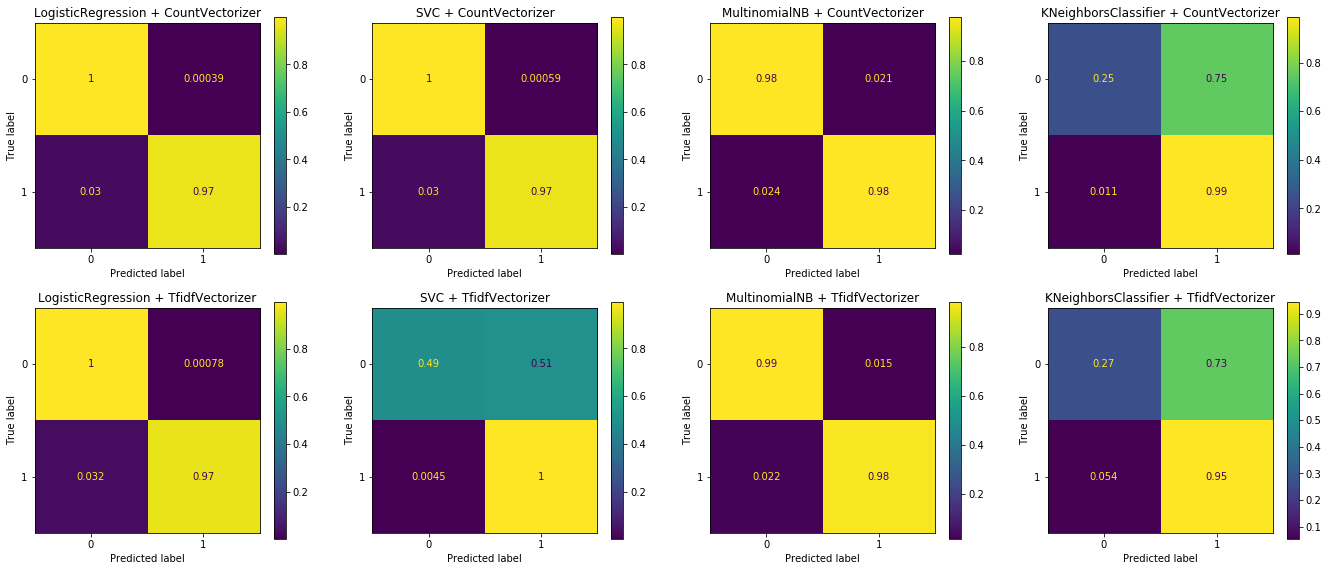

In [14]:
fig, ax = plt.subplots(nrows=len(vectorizers), ncols=len(classifiers), figsize=(5.8 * len(classifiers), 4.8 * len(vectorizers)))
predictions = (fit_predict(classifier, vectorizer, classifier_idx, vectorizer_idx) for classifier_idx, classifier in enumerate(classifiers) for vectorizer_idx, vectorizer in enumerate(vectorizers))
results = pd.DataFrame({
    clf_title: {
        score.__name__: score(y_test, y_pred) for score in scores
    }
    for clf_title, y_pred in predictions
})
plt.show()

## Что улучшать?
Нужно естественно стремиться к повышению *Accuracy*, второй задачей стоит повышение *Precision* к 1, даже если жертвуется *Recall*.

In [15]:
results.transpose().sort_values('accuracy_score', ascending=False)

,accuracy_score,f1_score,precision_score,recall_score
LogisticRegression + CountVectorizer,0.989989,0.984375,0.999165,0.970016
SVC + CountVectorizer,0.989726,0.983964,0.998748,0.969611
LogisticRegression + TfidfVectorizer,0.988936,0.982716,0.998328,0.967585
MultinomialNB + TfidfVectorizer,0.982877,0.973769,0.969855,0.977715
MultinomialNB + CountVectorizer,0.978003,0.966499,0.957092,0.976094
SVC + TfidfVectorizer,0.657403,0.653892,0.486824,0.995543
KNeighborsClassifier + TfidfVectorizer,0.491570,0.547479,0.385186,0.946110
KNeighborsClassifier + CountVectorizer,0.489989,0.557587,0.388288,0.988655


In [16]:
results.transpose().sort_values('accuracy_score', ascending=False).to_csv('docs/results.csv')